# Fine-tuning a masked language model (PyTorch)

Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
# To run the training on TPU, you will need to uncomment the following line:
# !pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!apt install git-lfs

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "you@example.com"
!git config --global user.name "Your Name"

You will also need to be logged in to the Hugging Face Hub. Execute the following and enter your credentials.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Picking a pretrained model for masked language modeling

To get started, let’s pick a suitable pretrained model for masked language modeling. As shown in the following screenshot, you can find a list of candidates by applying the “Fill-Mask” filter on the Hugging Face Hub:

Hub models.

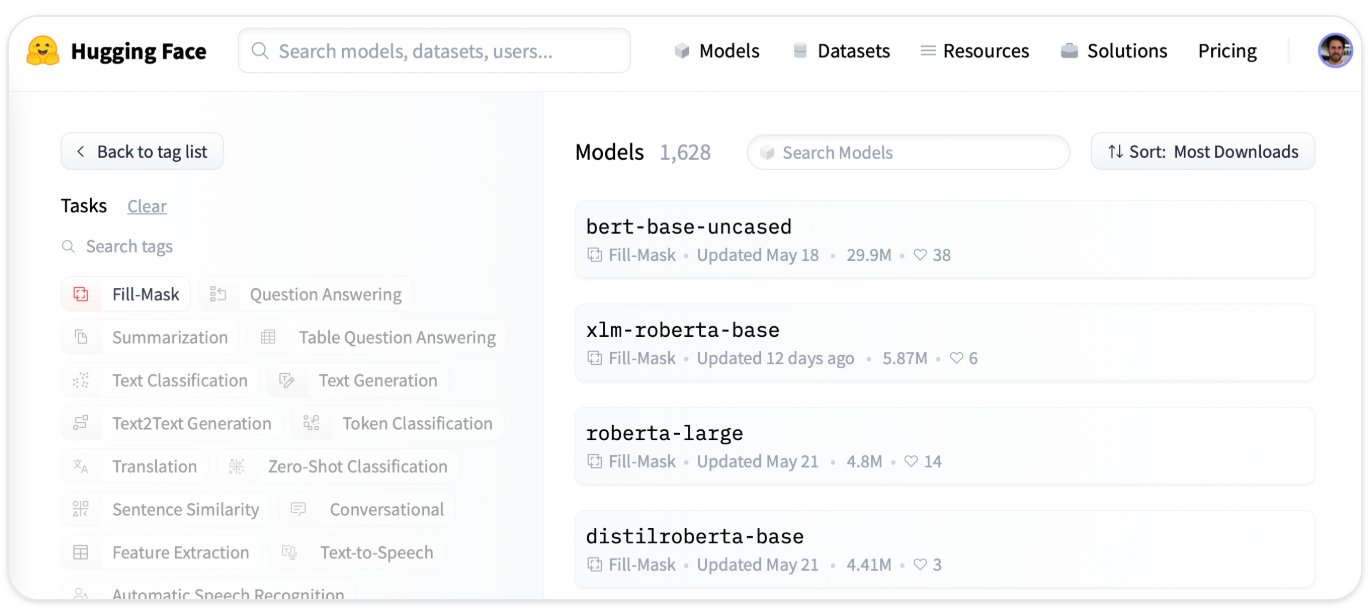

Although the BERT and RoBERTa family of models are the most downloaded, we’ll use a model called DistilBERT that can be trained much faster with little to no loss in downstream performance. This model was trained using a special technique called knowledge distillation, where a large “teacher model” like BERT is used to guide the training of a “student model” that has far fewer parameters. An explanation of the details of knowledge distillation would take us too far afield in this section, but if you’re interested you can read all about it in Natural Language Processing with Transformers (colloquially known as the Transformers textbook).

Let’s go ahead and download DistilBERT using the AutoModelForMaskedLM class:

In [1]:
from transformers import AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

We can see how many parameters this model has by calling the num_parameters() method:

In [2]:
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")
print(f"'>>> BERT number of parameters: 110M'")

'>>> DistilBERT number of parameters: 67M'
'>>> BERT number of parameters: 110M'


With around 67 million parameters, DistilBERT is approximately two times smaller than the BERT base model, which roughly translates into a two-fold speedup in training — nice! Let’s now see what kinds of tokens this model predicts are the most likely completions of a small sample of text:

In [3]:
text = "This is a great [MASK]."

As humans, we can imagine many possibilities for the [MASK] token, such as “day”, “ride”, or “painting”. For pretrained models, the predictions depend on the corpus the model was trained on, since it learns to pick up the statistical patterns present in the data. Like BERT, DistilBERT was pretrained on the English Wikipedia and BookCorpus datasets, so we expect the predictions for [MASK] to reflect these domains. To predict the mask we need DistilBERT’s tokenizer to produce the inputs for the model, so let’s download that from the Hub as well:

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [6]:
import torch

inputs = tokenizer(text, return_tensors="pt")
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1] # 1 index is the position from the tupple returned
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits
top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'")

'>>> This is a great deal.'
'>>> This is a great success.'
'>>> This is a great adventure.'
'>>> This is a great idea.'
'>>> This is a great feat.'


In [7]:
text

'This is a great [MASK].'

In [8]:
# The text is tokenized by the tokenizer
inputs

{'input_ids': tensor([[ 101, 2023, 2003, 1037, 2307,  103, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}

In [9]:
# The tokenized text is fed into the model which generates logits as the output.
print(token_logits.shape)
token_logits

torch.Size([1, 8, 30522])


tensor([[[ -5.5882,  -5.5868,  -5.5958,  ...,  -4.9448,  -4.8174,  -2.9905],
         [-11.9031, -11.8872, -12.0623,  ..., -10.9570, -10.6464,  -8.6324],
         [-11.9604, -12.1520, -12.1279,  ..., -10.0218,  -8.6074,  -8.0971],
         ...,
         [ -4.8228,  -4.6268,  -5.1041,  ...,  -4.2771,  -5.0184,  -3.9428],
         [-11.2945, -11.2388, -11.3857,  ...,  -9.2063,  -9.3411,  -6.1505],
         [ -9.5213,  -9.4632,  -9.5022,  ...,  -8.6561,  -8.4908,  -4.6903]]],
       grad_fn=<ViewBackward0>)

In [10]:
# Checking the token id of MASK
tokenizer.mask_token_id

103

In [11]:
# Finding the location of [MASK] and extract its logits
torch.where(inputs["input_ids"] == tokenizer.mask_token_id)

(tensor([0]), tensor([5]))

In [12]:
# Finding the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_index


tensor([5])

In [14]:
# Just curious about the content
mask_token_logits = token_logits[0, mask_token_index, :]
print(mask_token_logits.shape)
mask_token_logits

torch.Size([1, 30522])


tensor([[-4.8228, -4.6268, -5.1041,  ..., -4.2771, -5.0184, -3.9428]],
       grad_fn=<IndexBackward0>)

In [15]:
# Just curious about the content
tokenizer.mask_token

'[MASK]'

In [16]:
# Just curious about the content
top_5_tokens


[3066, 3112, 6172, 2801, 8658]

We can see from the outputs that the model’s predictions refer to everyday terms, which is perhaps not surprising given the foundation of English Wikipedia. Let’s see how we can change this domain to something a bit more niche — highly polarized movie reviews!

## The dataset

To showcase domain adaptation, we’ll use the famous Large Movie Review Dataset (or IMDb for short), which is a corpus of movie reviews that is often used to benchmark sentiment analysis models. By fine-tuning DistilBERT on this corpus, we expect the language model will adapt its vocabulary from the factual data of Wikipedia that it was pretrained on to the more subjective elements of movie reviews. We can get the data from the Hugging Face Hub with the load_dataset() function from 🤗 Datasets:

In [34]:
from datasets import load_dataset
# Load the datasert from HF hub
imdb_dataset = load_dataset("imdb")
imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

We can see that the train and test splits each consist of 25,000 reviews, while there is an unlabeled split called unsupervised that contains 50,000 reviews. Let’s take a look at a few samples to get an idea of what kind of text we’re dealing with. As we’ve done in previous chapters of the course, we’ll chain the Dataset.shuffle() and Dataset.select() functions to create a random sample:

In [35]:
sample = imdb_dataset["train"].shuffle(seed=42).select(range(3))

for row in sample:
    print(f"\n'>>> Review: {row['text']}'")
    print(f"'>>> Label: {row['label']}'")


'>>> Review: There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...'
'>>> Label: 1'

'>>> Review: This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stu

Yep, these are certainly movie reviews, and if you’re old enough you may even understand the comment in the last review about owning a VHS version 😜! Although we won’t need the labels for language modeling, we can already see that a 0 denotes a negative review, while a 1 corresponds to a positive one.

Now that we’ve had a quick look at the data, let’s dive into preparing it for masked language modeling. As we’ll see, there are some additional steps that one needs to take compared to the sequence classification tasks we saw in Chapter 3. Let’s go!

## Preprocessing the data

For both auto-regressive and masked language modeling, a common preprocessing step is to concatenate all the examples and then split the whole corpus into chunks of equal size. This is quite different from our usual approach, where we simply tokenize individual examples. Why concatenate everything together? The reason is that individual examples might get truncated if they’re too long, and that would result in losing information that might be useful for the language modeling task!

So to get started, we’ll first tokenize our corpus as usual, but without setting the truncation=True option in our tokenizer. We’ll also grab the word IDs if they are available ((which they will be if we’re using a fast tokenizer, as described in Chapter 6), as we will need them later on to do whole word masking. We’ll wrap this in a simple function, and while we’re at it we’ll remove the text and label columns since we don’t need them any longer:

In [36]:
def tokenize_function(examples):
  '''
  Tokenize our corpus as usual, but without setting the truncation=True option in our tokenizer,
  Also grab the word IDs if they are available.
  Remove the text and label columns since they are not needed any longer
  '''
  # Get the text. Only the text is required in this case since no labeling task is required
  result = tokenizer(examples["text"])
  if tokenizer.is_fast:
    # Create another column word_ids to store the grabed word_ids if exist
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
  return result


# Use batched=True to activate fast multithreading!
tokenized_datasets = imdb_dataset.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 50000
    })
})

Since DistilBERT is a BERT-like model, we can see that the encoded texts consist of the input_ids and attention_mask that we’ve seen in other chapters, as well as the word_ids we added.

Now that we’ve tokenized our movie reviews, the next step is to group them all together and split the result into chunks. But how big should these chunks be? This will ultimately be determined by the amount of GPU memory that you have available, but a good starting point is to see what the model’s maximum context size is. This can be inferred by inspecting the model_max_length attribute of the tokenizer:

In [37]:
tokenizer.model_max_length

512

This value is derived from the tokenizer_config.json file associated with a checkpoint; in this case we can see that the context size is 512 tokens, just like with BERT.

So, in order to run our experiments on GPUs like those found on Google Colab, we’ll pick something a bit smaller that can fit in memory:

In [38]:
chunk_size = 128

Note that using a small chunk size can be detrimental in real-world scenarios, so you should use a size that corresponds to the use case you will apply your model to.

Now comes the fun part. To show how the concatenation works, let’s take a few reviews from our tokenized training set and print out the number of tokens per review:

In [39]:
# Slicing produces a list of lists for each feature
tokenized_samples = tokenized_datasets["train"][:3]

for idx, sample in enumerate(tokenized_samples["input_ids"]):
    print(f"'>>> Review {idx} length: {len(sample)}'")

'>>> Review 0 length: 363'
'>>> Review 1 length: 304'
'>>> Review 2 length: 133'


We can then concatenate all these examples with a simple dictionary comprehension, as follows:

In [40]:
tokenized_samples.keys()

dict_keys(['input_ids', 'attention_mask', 'word_ids'])

In [27]:
tokenized_samples['input_ids']

[[101,
  1045,
  12524,
  1045,
  2572,
  8025,
  1011,
  3756,
  2013,
  2026,
  2678,
  3573,
  2138,
  1997,
  2035,
  1996,
  6704,
  2008,
  5129,
  2009,
  2043,
  2009,
  2001,
  2034,
  2207,
  1999,
  3476,
  1012,
  1045,
  2036,
  2657,
  2008,
  2012,
  2034,
  2009,
  2001,
  8243,
  2011,
  1057,
  1012,
  1055,
  1012,
  8205,
  2065,
  2009,
  2412,
  2699,
  2000,
  4607,
  2023,
  2406,
  1010,
  3568,
  2108,
  1037,
  5470,
  1997,
  3152,
  2641,
  1000,
  6801,
  1000,
  1045,
  2428,
  2018,
  2000,
  2156,
  2023,
  2005,
  2870,
  1012,
  1026,
  7987,
  1013,
  1028,
  1026,
  7987,
  1013,
  1028,
  1996,
  5436,
  2003,
  8857,
  2105,
  1037,
  2402,
  4467,
  3689,
  3076,
  2315,
  14229,
  2040,
  4122,
  2000,
  4553,
  2673,
  2016,
  2064,
  2055,
  2166,
  1012,
  1999,
  3327,
  2016,
  4122,
  2000,
  3579,
  2014,
  3086,
  2015,
  2000,
  2437,
  2070,
  4066,
  1997,
  4516,
  2006,
  2054,
  1996,
  2779,
  25430,
  14728,
  2245,
  2055,
  305

In [30]:
sum(tokenized_samples['input_ids'], [])

[111,
 101,
 1045,
 12524,
 1045,
 2572,
 8025,
 1011,
 3756,
 2013,
 2026,
 2678,
 3573,
 2138,
 1997,
 2035,
 1996,
 6704,
 2008,
 5129,
 2009,
 2043,
 2009,
 2001,
 2034,
 2207,
 1999,
 3476,
 1012,
 1045,
 2036,
 2657,
 2008,
 2012,
 2034,
 2009,
 2001,
 8243,
 2011,
 1057,
 1012,
 1055,
 1012,
 8205,
 2065,
 2009,
 2412,
 2699,
 2000,
 4607,
 2023,
 2406,
 1010,
 3568,
 2108,
 1037,
 5470,
 1997,
 3152,
 2641,
 1000,
 6801,
 1000,
 1045,
 2428,
 2018,
 2000,
 2156,
 2023,
 2005,
 2870,
 1012,
 1026,
 7987,
 1013,
 1028,
 1026,
 7987,
 1013,
 1028,
 1996,
 5436,
 2003,
 8857,
 2105,
 1037,
 2402,
 4467,
 3689,
 3076,
 2315,
 14229,
 2040,
 4122,
 2000,
 4553,
 2673,
 2016,
 2064,
 2055,
 2166,
 1012,
 1999,
 3327,
 2016,
 4122,
 2000,
 3579,
 2014,
 3086,
 2015,
 2000,
 2437,
 2070,
 4066,
 1997,
 4516,
 2006,
 2054,
 1996,
 2779,
 25430,
 14728,
 2245,
 2055,
 3056,
 2576,
 3314,
 2107,
 2004,
 1996,
 5148,
 2162,
 1998,
 2679,
 3314,
 1999,
 1996,
 2142,
 2163,
 1012,
 1999,
 209

In [41]:
# concatenate a list of lists of token IDs into a single, flat list.
concatenated_examples = {
    k: sum(tokenized_samples[k], []) for k in tokenized_samples.keys()
}
total_length = len(concatenated_examples["input_ids"])
print(f"'>>> Concatenated reviews length: {total_length}'")

'>>> Concatenated reviews length: 800'


Great, the total length checks out — so now let’s split the concatenated reviews into chunks of the size given by chunk_size. To do so, we iterate over the features in concatenated_examples and use a list comprehension to create slices of each feature. The result is a dictionary of chunks for each feature:

In [42]:
chunks = {
    k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
    for k, t in concatenated_examples.items()
}

for chunk in chunks["input_ids"]:
    print(f"'>>> Chunk length: {len(chunk)}'")

'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 128'
'>>> Chunk length: 32'


As you can see in this example, the last chunk will generally be smaller than the maximum chunk size. There are two main strategies for dealing with this:

Drop the last chunk if it’s smaller than chunk_size.
Pad the last chunk until its length equals chunk_size.
We’ll take the first approach here, so let’s wrap all of the above logic in a single function that we can apply to our tokenized datasets:

In [43]:
def group_texts(examples):
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

Note that in the last step of group_texts() we create a new labels column which is a copy of the input_ids one. As we’ll see shortly, that’s because in masked language modeling the objective is to predict randomly masked tokens in the input batch, and by creating a labels column we provide the ground truth for our language model to learn from.

Let’s now apply group_texts() to our tokenized datasets using our trusty Dataset.map() function:

In [ ]:
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 61289
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 59905
    })
    unsupervised: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 122963
    })
})

In [ ]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

".... at.......... high. a classic line : inspector : i'm here to sack one of your teachers. student : welcome to bromwell high. i expect that many adults of my age think that bromwell high is far fetched. what a pity that it isn't! [SEP] [CLS] homelessness ( or houselessness as george carlin stated ) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. most people think of the homeless"

In [ ]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
for sample in samples:
    _ = sample.pop("word_ids")

for chunk in data_collator(samples)["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

In [ ]:
import collections
import numpy as np

from transformers import default_data_collator

wwm_probability = 0.2


def whole_word_masking_data_collator(features):
    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

In [ ]:
samples = [lm_datasets["train"][i] for i in range(2)]
batch = whole_word_masking_data_collator(samples)

for chunk in batch["input_ids"]:
    print(f"\n'>>> {tokenizer.decode(chunk)}'")

'>>> [CLS] bromwell high is a cartoon comedy [MASK] it ran at the same time as some other programs about school life, such as " teachers ". my 35 years in the teaching profession lead me to believe that bromwell high\'s satire is much closer to reality than is " teachers ". the scramble to survive financially, the insightful students who can see right through their pathetic teachers\'pomp, the pettiness of the whole situation, all remind me of the schools i knew and their students. when i saw the episode in which a student repeatedly tried to burn down the school, i immediately recalled.....'

'>>> .... [MASK] [MASK] [MASK] [MASK]....... high. a classic line : inspector : i\'m here to sack one of your teachers. student : welcome to bromwell high. i expect that many adults of my age think that bromwell high is far fetched. what a pity that it isn\'t! [SEP] [CLS] homelessness ( or houselessness as george carlin stated ) has been an issue for years but never a plan to help those on the st

In [ ]:
train_size = 10_000
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'word_ids'],
        num_rows: 1000
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import TrainingArguments

batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-imdb",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
)

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

In [ ]:
import math

eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 21.75

In [ ]:
trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 11.32

In [ ]:
trainer.push_to_hub()

In [ ]:
def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

In [ ]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

In [ ]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
from huggingface_hub import get_full_repo_name

model_name = "distilbert-base-uncased-finetuned-imdb-accelerate"
repo_name = get_full_repo_name(model_name)
repo_name

'lewtun/distilbert-base-uncased-finetuned-imdb-accelerate'

In [ ]:
from huggingface_hub import Repository

output_dir = model_name
repo = Repository(output_dir, clone_from=repo_name)

In [ ]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

>>> Epoch 0: Perplexity: 11.397545307900472
>>> Epoch 1: Perplexity: 10.904909330983092
>>> Epoch 2: Perplexity: 10.729503505340409

In [ ]:
from transformers import pipeline

mask_filler = pipeline(
    "fill-mask", model="huggingface-course/distilbert-base-uncased-finetuned-imdb"
)

In [ ]:
preds = mask_filler(text)

for pred in preds:
    print(f">>> {pred['sequence']}")

'>>> this is a great movie.'
'>>> this is a great film.'
'>>> this is a great story.'
'>>> this is a great movies.'
'>>> this is a great character.'